In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "Inter";
        font-size: 15px;``
    }
</style>

# **Dependencies**
* Pandas
* Plotly
* nbformat

# **Distance Running Predictions**

The objective of this project is to create a model that predicts race time given the distance and your history of running performance

In [2]:
import plotly.graph_objects as go
import pandas as pd

onedark_theme = {
    'red': '#e06c75',
    'bg': '#23272e',
    'txt': '#8b8d90',
    'txt_dark': '#1e2227'
    }
vs_lightplus = {
    'red': '#cd3131',
    'bg': '#ffffff',
    'txt': '#868686',
    'txt_dark': '#c9c9c9'
    }
github = {
    'red': '#ba2121',
    'bg': '#ffffff',
    'txt': '#212121',
    'txt_dark': '#b5b5b5'
    }
theme = onedark_theme

def choose_label(_name,dotname,axis):

    if _name is not None and dotname is not None:
        return _name
    elif _name is not None and dotname is None:
        return _name
    elif _name is None and dotname is not None:
        return dotname
    else:
        return axis

def my_scatter(x,y,z,
               c=theme['red'],
               cmap='viridis',
               aspectratio=dict(x=1,y=1,z=1),
               height=None,
               width=None,
               markersize=5
               ):
    '''
    Helper function that plots a scatter using plotly

    c: list or np.ndarray or pd.Series - the numerical value associated with the colour map
    cmap: string - colour map
    aspectratio: dict - aspect ratio 

    '''

    x = pd.Series(x)
    y = pd.Series(y)
    z = pd.Series(z)


    trace_data = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=markersize,
            color=c,
            colorscale=cmap,
            opacity=0.8
        )
    )

    fig = go.Figure(data = trace_data)

    fig.update_layout(
        autosize=False if not (height is None and width is None) else True,
        width=width,
        height=height,
        margin = dict(l=0,r=0,b=0,t=0),
        paper_bgcolor=theme['bg'],
        font_color = theme['txt'],
        scene = dict(
            xaxis = dict(     
                title = 'x' if x.name is None else x.name,
                backgroundcolor=theme['bg'],
                gridcolor=theme['txt'],
                showbackground=True,
                zerolinecolor=theme['txt'],
                titlefont=dict(family='Inter')
                # range=
            ),
            yaxis = dict(
                title = 'y' if y.name is None else y.name,
                backgroundcolor=theme['bg'],
                gridcolor=theme['txt'],
                showbackground=True,
                zerolinecolor=theme['txt'],
                titlefont=dict(family='Inter')
                # range=
            ),
            zaxis = dict(
                title = 'z' if z.name is None else z.name,
                backgroundcolor=theme['bg'],
                gridcolor=theme['txt'],
                showbackground=True,
                zerolinecolor=theme['txt'],
                titlefont=dict(family='Inter')
                # range=
            ),
            aspectratio=aspectratio,
            camera = dict(projection_type="orthographic")
        )
    )

    return fig

import plotly.express as px

def my_barchart(x: pd.Series,                
                y: pd.Series,
                x_name=None,
                y_name=None,
                width=None,
                height=None,
                ):
    
    x=pd.Series(x)
    y=pd.Series(y)
    x_name = choose_label(x_name,x.name,'x')
    y_name = choose_label(y_name,y.name,'y')
    
    df= pd.DataFrame({x.name: x, y.name: y})

    fig = px.bar(df,x=x,y=y)

    fig.update_xaxes(gridcolor=theme['txt_dark'], title_text=x_name, title_font=dict(family='Inter'), linecolor=theme['txt'], linewidth=3)
    fig.update_yaxes(gridcolor=theme['txt_dark'], title_text=y_name, title_font=dict(family='Inter'))
    fig.update_traces(marker=dict(line=dict(color=theme['txt_dark'])))

    fig.update_layout(
        autosize=False if not (height is None and width is None) else True,
        width=width,
        height=height,
        margin = dict(l=0,r=0,b=0,t=0),
        paper_bgcolor=theme['bg'],
        plot_bgcolor=theme['bg'],
        font_color = theme['txt'],
    )

    return fig

def my_cumulative(x, x_name = None, y_name = None):

    x = pd.Series(x)
    x_name = choose_label(x_name,x.name,'x')
    df = pd.DataFrame({x_name: x})

    y_name = 'Cumulative Distribution' if y_name is None else y_name

    fig = px.ecdf(df,x=x_name)

    fig.update_xaxes(gridcolor=theme['txt'], title_text=x_name, title_font=dict(family='Inter'), linecolor=theme['txt'], linewidth=3)
    fig.update_yaxes(gridcolor=theme['txt'], title_text=y_name, title_font=dict(family='Inter'))
    fig.update_traces(line=dict(color=theme['red'],width=5))


    fig.update_layout(
        margin = dict(l=50,r=50,b=50,t=50),
        paper_bgcolor=theme['bg'],
        plot_bgcolor=theme['bg'],
        font_color = theme['txt'],
    )

    return fig

def my_freqdist(x,x_name=None,height=None,width=None,n_bins=None):

    x=pd.Series(x)
    x_name = choose_label(x_name,x.name,'x')
    df=pd.DataFrame({x_name:x.values})

    fig = px.histogram(df,x_name,nbins=n_bins)
    
    fig.update_xaxes(gridcolor=theme['txt'], title_text=x_name, title_font=dict(family='Inter'), linecolor=theme['txt'], linewidth=3)
    fig.update_yaxes(gridcolor=theme['txt'], title_font=dict(family='Inter'))

    fig.update_traces(marker_color=theme['red'])
    

    fig.update_layout(
        margin = dict(l=50,r=50,b=50,t=50),
        autosize=True if (height is None and width is None) else False,
        width=width,
        height=height,
        paper_bgcolor=theme['bg'],
        plot_bgcolor=theme['bg'],
        font_color = theme['txt'],
    )

    return fig

def my_xyscatter(x,y,x_name=None,y_name=None,height=None,width=None):

    x=pd.Series(x)
    x_name = choose_label(x_name,x.name,'x')
    y=pd.Series(y)
    y_name = choose_label(y_name,y.name,'y')

    fig = go.Figure(data=go.Scatter(
        x=x, 
        y=y, 
        mode='markers',
        marker=dict(color=theme['red']))
    )  


    fig.update_xaxes(title_text=x_name, title_font=dict(family='Inter'), linecolor=theme['txt'])
    fig.update_yaxes(title_text=y_name, title_font=dict(family='Inter'))
    # fig.update_traces(marker=dict(line=dict(color=theme['txt_dark'])))

    fig.update_layout(
        margin = dict(l=50,r=50,b=50,t=50),
        autosize=True if (height is None and width is None) else False,
        width=width,
        height=height,
        xaxis=dict(gridcolor=theme['txt'], zerolinecolor=theme['txt']),
        yaxis=dict(gridcolor=theme['txt'], zerolinecolor=theme['txt']),
        paper_bgcolor=theme['bg'],
        plot_bgcolor=theme['bg'],
        font_color = theme['txt'],
    )

    return fig

def my_xyscatter(x, y, x_name=None, y_name=None, height=4, width=6):
    x = pd.Series(x)
    y = pd.Series(y)
    x_name = choose_label(x_name, x.name, 'x')
    y_name = choose_label(y_name, y.name, 'y')

    fig, ax = plt.subplots(figsize=(width, height))

    ax.scatter(x, y, color=theme['red'])

    ax.set_xlabel(x_name, fontfamily='Inter', color=theme['txt'])
    ax.set_ylabel(y_name, fontfamily='Inter', color=theme['txt'])

    ax.spines['bottom'].set_color(theme['txt'])
    ax.spines['top'].set_color(theme['txt']) 
    ax.spines['right'].set_color(theme['txt'])
    ax.spines['left'].set_color(theme['txt'])

    ax.tick_params(axis='x', colors=theme['txt'])
    ax.tick_params(axis='y', colors=theme['txt'])

    ax.set_axisbelow(True)
    ax.grid(True, color=theme['txt'], linestyle='--', linewidth=0.5)

    fig.patch.set_facecolor(theme['bg'])
    ax.set_facecolor(theme['bg'])

    plt.show()

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

def my_freqdist(x, x_name=None, height=4, width=8, n_bins=20, xlim:list=None, ylim:list=None):
    '''
    Helper function that plots a histogram using matplotlib.pyplot

    x: list or np.ndarray or pd.Series - data values
    x_name: string - label for x-axis
    height: float - figure height
    width: float - figure width
    n_bins: int - number of bins for the histogram
    '''

    x = pd.Series(x)
    x_name = choose_label(x_name, x.name, 'x')

    fig, ax = plt.subplots(figsize=(width,height))

    counts, bins, _ = ax.hist(x, bins=n_bins, color=theme['red'], edgecolor=theme['txt_dark'], linewidth=1.5, zorder=2)

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlabel(x_name, fontfamily='Inter', color=theme['txt'])
    ax.set_ylabel('Frequency', fontfamily='Inter', color=theme['txt'])

    ax.grid(color=theme['txt'], linestyle='--', linewidth=0.5, zorder=1)

    fig.patch.set_facecolor(theme['bg'])
    ax.set_facecolor(theme['bg'])

    for tick in ax.get_xticklabels():
        tick.set_fontfamily('Inter')
        tick.set_color(theme['txt'])
    for tick in ax.get_yticklabels():
        tick.set_fontfamily('Inter')
        tick.set_color(theme['txt'])

    for spine in ax.spines.values():
        spine.set_edgecolor(theme['txt'])

    plt.show()

def my_barchart(x, y, x_name=None, y_name=None, width=None, height=None):
    x = pd.Series(x)
    y = pd.Series(y)
    x_name = choose_label(x_name, x.name, 'x')
    y_name = choose_label(y_name, y.name, 'y')

    fig, ax = plt.subplots(figsize=(width, height))

    ax.bar(x, y, color=theme['bg'], edgecolor=theme['txt_dark'], linewidth=3)

    ax.set_xlabel(x_name, fontfamily='Inter', color=theme['txt'])
    ax.set_ylabel(y_name, fontfamily='Inter', color=theme['txt'])
    ax.set_facecolor(theme['bg'])
    fig.patch.set_facecolor(theme['bg'])

    ax.spines['bottom'].set_color(theme['txt'])
    ax.spines['top'].set_color(theme['txt']) 
    ax.spines['right'].set_color(theme['txt'])
    ax.spines['left'].set_color(theme['txt'])

    ax.tick_params(axis='x', colors=theme['txt'])
    ax.tick_params(axis='y', colors=theme['txt'])

    plt.show()

def my_cumulative(x, x_name=None, y_name=None):
    x = pd.Series(x)
    x_name = choose_label(x_name, x.name, 'x')
    y_name = 'Cumulative Distribution' if y_name is None else y_name

    fig, ax = plt.subplots()

    # Calculate the ECDF
    x_sorted = np.sort(x)
    y_values = np.arange(1, len(x_sorted)+1) / len(x_sorted)

    ax.plot(x_sorted, y_values, color=theme['red'], linewidth=5)

    ax.set_xlabel(x_name, fontfamily='Inter', color=theme['txt'])
    ax.set_ylabel(y_name, fontfamily='Inter', color=theme['txt'])

    ax.spines['bottom'].set_color(theme['txt'])
    ax.spines['top'].set_color(theme['txt']) 
    ax.spines['right'].set_color(theme['txt'])
    ax.spines['left'].set_color(theme['txt'])

    ax.tick_params(axis='x', colors=theme['txt'])
    ax.tick_params(axis='y', colors=theme['txt'])

    # Set grid lines behind other elements
    ax.set_axisbelow(True)
    ax.grid(True, color=theme['txt'], linestyle='--', linewidth=0.5)

    fig.patch.set_facecolor(theme['bg'])
    ax.set_facecolor(theme['bg'])

    plt.show()

In [4]:
import numpy as np
from datetime import datetime

# import the dataset as a DataFrame
data = pd.read_csv("data/raw-data-kaggle.csv", delimiter=";")

data.head()

,athlete,gender,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm)
0,18042525,M,15/12/2019 09:08,2965.8,812,17.4,150.3
1,18042525,M,10/12/2019 19:27,10020.8,3290,52.2,160.8
2,18042525,M,03/12/2019 19:46,12132.2,4027,249.0,148.9
3,18042525,M,26/11/2019 19:46,11631.5,4442,194.0,136.2
4,18042525,M,19/11/2019 19:45,11708.1,4022,250.7,146.0


In [5]:
print(f'Number of unique athletes: {data["athlete"].nunique()}')
print(f'Number of genders: {data["gender"].nunique()}')
print(f"Precision of elevation gain: {data['elevation gain (m)'].apply(lambda x: len(str(x).split('.')[1]) if '.' in str(x) else 0).max()} m")

Number of unique athletes: 116
Number of genders: 2
Precision of elevation gain: 1 m


The raw data contains 42,116 data points. There are 7 variables in the data. 

Some observations:
* ```gender``` appears is boolean in nature (only either Male or Female)
* ```athlete``` is categorical data recorded as the numerical user ID. 
* Despite there being so many data points, there are only 116 different athletes - this means there is a lot of data per athlete.
* The other 5 columns are continuous numerical data. However, elevation gain is recorded as an integer.

# **Exploratory Data Analysis (EDA)**

The objectives of EDA are:
1. Confirm if the data is suitable for the application
1. Discover and resolve data quality issues (missing data, duplicates, incorrect values, anomalies, incorrect data types)
1. Check the data's mean, median, mode skewness, range, count etc.
1. Detect outliers and anomalies
1. Understand data patterns and correlations between variables

## **Data Cleaning**

### **Extracting Useful Columns**


I would like to make the running time predictions based solely on an individual's performance. Therefore, I will be excluding gender as a parameter for the model.

In [6]:
data = data.drop(columns = 'gender')

All the other columns should be useful and will be kept

### **Variable Formatting**

Here I'll check if every row of each column has the same data type, and if each column has the appropriate data type.

In [7]:
data.dtypes

athlete                       int64
timestamp                    object
distance (m)                float64
elapsed time (s)              int64
elevation gain (m)          float64
average heart rate (bpm)    float64
dtype: object

In [8]:
# convert timestamp to dtype datetime 
data["timestamp"] = pd.to_datetime(data["timestamp"])

C:\Users\hobly\AppData\Local\Temp\ipykernel_15576\3259052015.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data["timestamp"] = pd.to_datetime(data["timestamp"])


In [9]:
data.dtypes

athlete                              int64
timestamp                   datetime64[ns]
distance (m)                       float64
elapsed time (s)                     int64
elevation gain (m)                 float64
average heart rate (bpm)           float64
dtype: object

In [10]:
data.max()

athlete                                46817575
timestamp                   2020-01-06 05:24:00
distance (m)                           218950.0
elapsed time (s)                        2971531
elevation gain (m)                      12078.5
average heart rate (bpm)                  237.0
dtype: object

In [11]:
data.min()

athlete                                  771514
timestamp                   2000-01-04 12:06:00
distance (m)                                0.0
elapsed time (s)                              0
elevation gain (m)                          0.0
average heart rate (bpm)                    0.0
dtype: object

From looking at the minimum values, the distance, elapsed time and heart rate data have missing values that are not flagged as null.

### **Missing Values**

Let's check if there are null, nan or missing values anywhere

In [12]:
data.isnull().sum()

athlete                         0
timestamp                       0
distance (m)                    0
elapsed time (s)                0
elevation gain (m)              0
average heart rate (bpm)    18384
dtype: int64

In [13]:
print(f'Average number of rows per athlete: {data.shape[0]/data["athlete"].nunique():.2f}')
print(f'Percentage of rows that are missing heart rate: {23732/42116*100:.1f} %')

Average number of rows per athlete: 363.07
Percentage of rows that are missing heart rate: 56.3 %


From the above, we see that there are null values in the gender and heart rate columns. 

The more problematic column is average heart rate, which has a null value in the majority of its rows. <!-- While this would have been an extremely useful metric to infer athlete capability and race times, there is insufficient data to safely impute the missing values. Therefore, heart rate should be omitted as a variable in the model on the basis of insufficient data. -->

<!-- Let's not exclude heart rate just yet! Let's check the proportion of athletes with heart rate data entirely missing. If too many athletes are missing heart rate data entirely, it is not a useful metric. If each athlete has a proportionally small amount of heart rate data missing, we can impute it per-athlete, given the large amount of data per-athlete. -->

**Feature Engineering: Pace (minutes per km)**

Before I analyse heart rate, I'll create a new feature for each row: pace. This is the average speed of the run in units of minutes per kilometre. This will allow be to do further data analysis based on the average speed of the runs.

Pace will be used to analyse the data, but won't be used as an input or output for the models.

In [14]:
data["pace (min/km)"] = (data["elapsed time (s)"]/60)/(data["distance (m)"]/1000)

#### **Missing Data: Heart Rate**

In [15]:
# count the number of athletes that are entirely missing any heart rate data
allnull = data.groupby('athlete')['average heart rate (bpm)'].apply(lambda x: x.isnull().all()).sum()

print(f'There are {allnull} athletes that have no heart rate data at all.')

# count the number of rows with missing heart rate per athlete, as a proportion of their total number of rows
null_counts = data[data['average heart rate (bpm)'].isnull()].groupby('athlete').size()
row_per_athlete = data.groupby('athlete').size()
nullpc_per_athlete = null_counts/row_per_athlete

print(f'{(nullpc_per_athlete>0.4).sum()/len(nullpc_per_athlete)*100:.1f}% of athletes have no heart rate data in more than 40% of their recorded runs')

There are 10 athletes that have no heart rate data at all.
50.0% of athletes have no heart rate data in more than 40% of their recorded runs


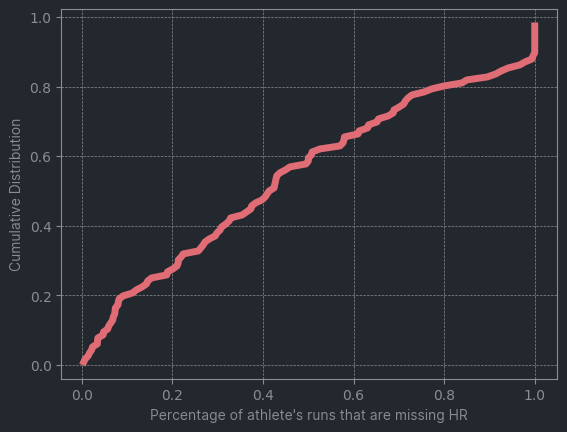

In [16]:
my_cumulative(nullpc_per_athlete, x_name="Percentage of athlete's runs that are missing HR")

##### **Discussion on Heart Rate**
Half of the athletes are missing HR data on >40% of their runs. There is insufficient data to impute the missing values. One option is to omit heart rate from the variables on which the models will be trained.

Alternatively, I could ignore the 56% of data that is missing heart rate, and only keep the remaining data. While I would be throwing away 56% of the data, there are still 26 thousand data points, which could be ample for my application. Heart rate is a very useful metric as it is the only objective variable in the dataset that indicates the level of effort exerted on a run.

On the basis of the importance of heart rate as a indicative parameter, I will choose to exclude all the data without heart rate.

In [17]:
data[data['average heart rate (bpm)'] == 0.0].size/len(data)*100

0.3988982809383607

In [18]:
data = data.dropna(subset=['average heart rate (bpm)']) # drop rows with missing heart rate
print(f"I've now got {data.shape[0]} data points")

I've now got 23732 data points


With the dropped rows, lets see how many runs each athelete has recorded.

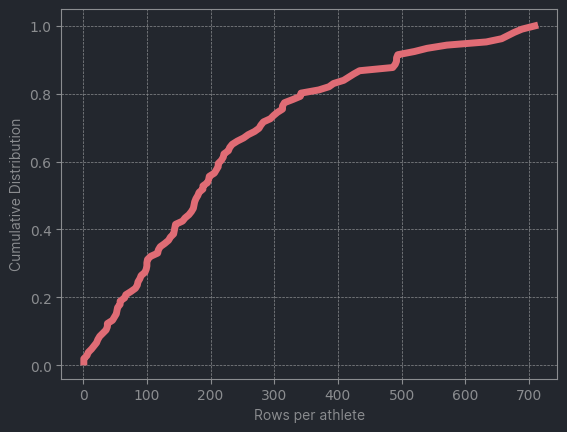

In [19]:
row_per_athlete = data.groupby('athlete').size()
my_cumulative(row_per_athlete, x_name="Rows per athlete")
# my_freqdist(row_per_athlete,x_name="Rows per athlete",n_bins=100)

70% of athletes have at least 100 data points. 

### **Drop Duplicates**

In [20]:
data = data.drop_duplicates()

print(f'There are now {data.shape[0]} rows that are unique')

There are now 23726 rows that are unique


## **Univariate Analysis**

### **Univariate Analysis: Heart Rate**

In [21]:
print(f"Number of rows with 0.0 BPM heart rate: {data[data['average heart rate (bpm)'] == 0.0].size}")
print(f"This is {data[data['average heart rate (bpm)'] == 0.0].size*100/data.shape[0]:.1f}% of the data")

Number of rows with 0.0 BPM heart rate: 168
This is 0.7% of the data


As a rule-of-thumb, I will impute if the missing data is more than 2% but less than 10%. Therefore I will not impute the missing data for heart rate = 0.0 BPM.

In [22]:
data.drop(data[data['average heart rate (bpm)'] == 0.0].index, inplace=True)
print(f"I've now got {data.shape[0]} data points with heart rate data")

I've now got 23702 data points with heart rate data


The world record for the slowest resting heart rate in a healthy human is 27 BPM. Therefore, runs with average heart rate below this value are practically impossible. While the average person would have a resting heart rate of 80 BPM, it is possible for athletes to have resting heart rates as low as 40 BPM.

In [23]:
data[data['average heart rate (bpm)']<40]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km)
806,10825360,2019-12-30 09:34:00,17393.0,12745,807.0,36.9,12.212768
31292,12642956,2019-01-04 14:14:00,2471.0,9327,0.0,26.8,62.909753


The low heart rates above do not appear to be errors, as they are accompanied by extremely slow paces, but I will remove them as these paces will not be beneficial to the dataset. The upper end of the maximum heart rate is not implausible.

In [24]:
data.drop(data[data['average heart rate (bpm)']<40].index, inplace=True)
print(f"I've now got {data.shape[0]} data points")

I've now got 23700 data points


In [25]:
hr_sorted = np.sort(data['average heart rate (bpm)'].values)
hr_sorted[:10]

array([41.3, 44.7, 54.1, 54.9, 56.8, 57. , 57.1, 62. , 63.9, 64. ])

The lowest heart rates are still too low for running distances. To determine whether these must be removed, I must look at the data on a per-runner basis in the next step.

The highest heart rate ever recorded in a human is 600 BPM.

In [26]:
data[data['average heart rate (bpm)']>600]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km)


There is no data that exceeds 600 BPM that I can delete on the basis of being implausible.

In [27]:
data["average heart rate (bpm)"].max()

237.0

The highest heart rate in my data is within reason.

#### **Graphical & Numerical Analysis**

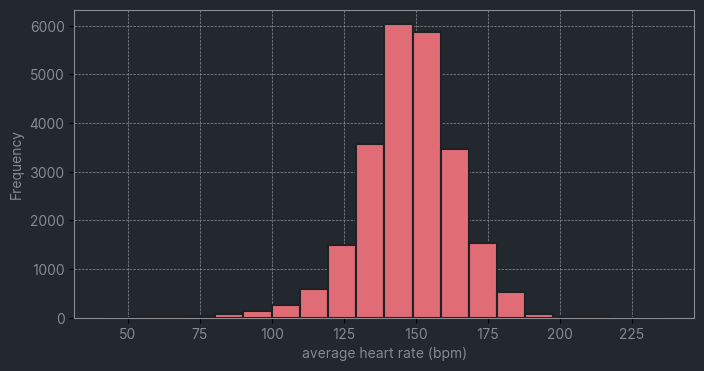

In [28]:
my_freqdist(data['average heart rate (bpm)'])

The data is slightly skewed to the right.

In [29]:
print("skewness: %f" % data['average heart rate (bpm)'].skew())
print("kurtosis: %f" % data['average heart rate (bpm)'].kurt())

skewness: -0.538677
kurtosis: 1.923665


In [30]:
from sklearn.preprocessing import StandardScaler

# standardise the data PER athlete
data['standardised_hr'] = data.groupby('athlete')['average heart rate (bpm)'].transform(lambda x: (x - x.mean()) / x.std())

# flag the row if hr standard deviation is too large
data['flag'] = (data['standardised_hr'] > 3) | (data['standardised_hr'] < -3)

data[(data['flag'] == True)]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag
334,7191483,2019-01-06 09:02:00,13323.6,3817,134.7,62.0,4.774736,-6.352060,True
821,10825360,2019-11-21 18:10:00,11387.0,3665,160.0,104.6,5.364304,-4.703039,True
823,10825360,2019-11-17 08:41:00,1897.0,795,30.0,106.4,6.984713,-4.571985,True
845,10825360,2019-10-06 07:32:00,1788.0,667,5.0,118.3,6.217375,-3.705567,True
849,10825360,2019-10-05 05:39:00,1512.0,611,0.0,113.9,6.735009,-4.025923,True
...,...,...,...,...,...,...,...,...,...
41257,5035018,2019-01-17 10:32:00,19338.3,12720,1285.8,123.5,10.962701,-3.746396,True
41413,5035018,2018-02-13 19:08:00,1608.0,854,2.4,116.6,8.851575,-4.460997,True
41499,5035018,2017-08-15 19:11:00,1517.1,984,19.1,121.5,10.810098,-3.953527,True
41501,5035018,2017-08-15 17:42:00,1547.7,702,2.2,124.3,7.559605,-3.663544,True


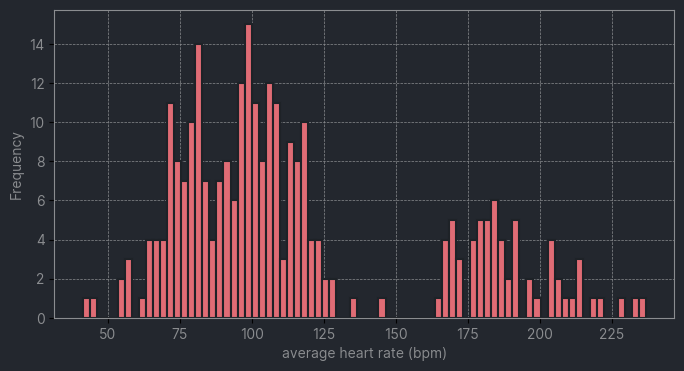

In [31]:
my_freqdist(data[(data['flag'] == True)]["average heart rate (bpm)"], n_bins=80)

Drop the rows that have an outlier heart rate, considering each athlete's individual mean heart rate.

In [32]:
data.drop(data[data['flag'] == True].index, inplace=True)
print(f"I've now got {data.shape[0]} data points")

I've now got 23422 data points


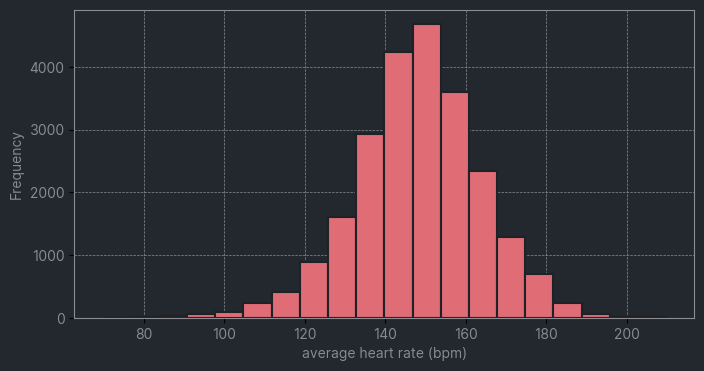

In [33]:
my_freqdist(data['average heart rate (bpm)'])

### **Univariate Analysis: Distance**

From the previous step, I know that no distance values are missing. Let's check if any distance values are 0.

In [34]:
data[data["elevation gain (m)"] == 0]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag
114,18042525,2018-01-09 19:46:00,2126.2,726,0.0,123.0,5.690904,-1.630601,False
161,18042525,2017-05-04 16:09:00,9539.6,2972,0.0,143.4,5.192391,-0.026524,False
163,18042525,2017-04-27 16:37:00,6177.7,1679,0.0,158.0,4.529733,1.121492,False
167,18042525,2017-04-17 15:17:00,5160.3,1405,0.0,154.0,4.537850,0.806967,False
170,18042525,2017-03-31 16:49:00,5253.1,1419,0.0,158.7,4.502104,1.176534,False
...,...,...,...,...,...,...,...,...,...
41292,5035018,2018-11-14 18:47:00,447.5,204,0.0,151.3,7.597765,-0.867276,False
41304,5035018,2018-10-17 17:43:00,548.6,215,0.0,150.3,6.531778,-0.970842,False
41519,5035018,2017-07-02 08:36:00,1483.1,431,0.0,161.2,4.843459,0.158022,False
41559,5035018,2017-03-20 12:40:00,2725.1,803,0.0,161.9,4.911135,0.230517,False


In [35]:
print(f'There are {data[data["distance (m)"] == 0].shape[0]} rows without distance data')
print(f'All rows missing distance are also missing elevation: {np.all(data[data["distance (m)"] == 0] == data[(data["distance (m)"] == 0) & (data["elevation gain (m)"] == 0)])}')
data[(data["distance (m)"] == 0) & (data["elapsed time (s)"] < 10)]

There are 22 rows without distance data
All rows missing distance are also missing elevation: True


,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag
8032,6215611,2018-04-21 14:32:00,0.0,4,0.0,111.3,inf,-1.680656,False
13893,12740383,2019-12-18 06:38:00,0.0,2,0.0,119.0,inf,-1.868945,False
40981,5688059,2014-01-21 20:10:00,0.0,4,0.0,123.0,inf,-1.986620,False
40986,5688059,2014-01-15 19:42:00,0.0,4,0.0,114.0,inf,-2.644202,False


Many of the rows without distance also have unrealistically short elapsed time. All of the rows without distance are also missing elevation gain. As the rows missing distance are also missing other data, I'll delete them instead of imputing the missing data. This will prevent the creation of data points that are too artificial.

In [36]:
data.drop(data[data["distance (m)"] == 0.0].index, inplace=True)
print(f"I've now got {data.shape[0]} data points")

I've now got 23400 data points


**Remove sprint distances, too** - these could distort the model by creating a more complicated 'surface'

Above distances of 1500m (~1 mile), there is a significantly higher proportion of aerobic activity compared to shorter distances. Anecdotally, this is also the distance above which most non-runners cannot complete while running throughout. Therefore, I'll use this as our cut-off point. 

<[source](https://readysetmarathon.com/what-is-considered-distance-running/)>


In [37]:
data.drop(data[data["distance (m)"] < 1500].index, inplace=True)
print(f"I've now got {data.shape[0]} data points")

I've now got 22960 data points


In [38]:
print(f'Longest distance: {data["distance (m)"].max()}')
data[data["distance (m)"] == data["distance (m)"].max()]

Longest distance: 218950.0


,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag
16127,17639804,2018-10-18 19:59:00,218950.0,96372,9729.0,134.0,7.335921,-1.099759,False


The data row with the longest distance is implausible. The elapsed time is greater than a day, and the elevation gain is greater than Mount Everest. I'll go through time and elevation later on, so I'll leave this row in here for now.

### **Univariate Analysis: Elevation**

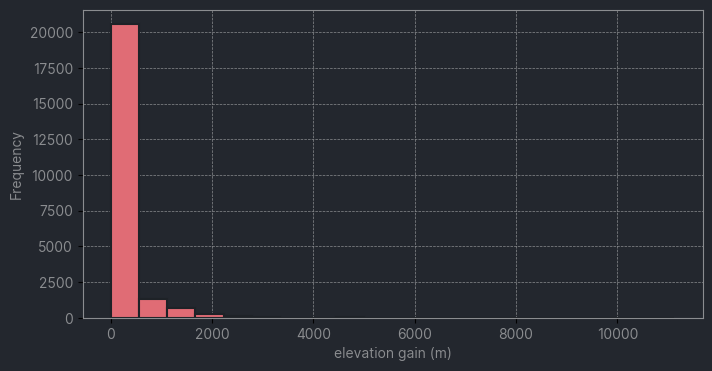

In [39]:
my_freqdist(data["elevation gain (m)"])

Elevation can't be eliminated on the basis of standard deviation. Outliers of elevation can still be perfectly valid. Therefore, I must eliminate based on what is actually possible and what is productive towards creating a good generalisable dataset.

In [40]:
print(f'Highest elevation gain: {data["elevation gain (m)"].max()} m')
print(f'{data[data["elevation gain (m)"] > 8849].shape[0]} rows with elevation gain higher than Mount Everest')

Highest elevation gain: 11128.0 m
2 rows with elevation gain higher than Mount Everest


The highest elevation gain in the data is 11,128 m. This is taller than Mount Everest, which is "only" 8,849 m high. I'll delete the row

In [41]:
data.drop(data[data["elevation gain (m)"] > 8849].index, inplace=True)

To assess whether a high elevation gain is valid, I'll do some **feature engineering** and construct a new feature: **gradient**, which is elevation divided by distance, expressed as a percentage.

In [42]:
data["gradient (%)"] = (data["elevation gain (m)"]/data["distance (m)"])*100
data[data["elevation gain (m)"] > 5000]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%)
1031,10825360,2018-08-25 03:03:00,84278.0,52978,5450.0,157.5,10.476835,-0.851487,False,6.466694
13979,12740383,2019-06-28 02:00:00,90281.0,55226,5736.0,141.0,10.195205,-0.448842,False,6.353496
16161,17639804,2018-08-25 03:03:00,84149.3,47334,5245.0,146.4,9.375004,-0.104441,False,6.232969
40687,5688059,2016-05-06 03:08:00,126145.0,66815,7547.7,131.3,8.827804,-1.380183,False,5.983352


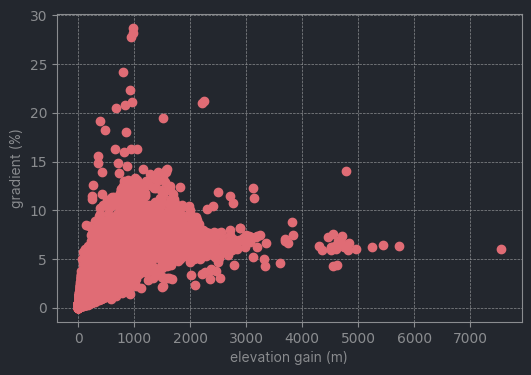

In [43]:
my_xyscatter(data["elevation gain (m)"], data["gradient (%)"])

From the graphical analysis above, I can see that the data points with very high elevation gain also have fairly normal gradient. The data points with very high gradient do not have implausible elevation. Therefore, I don't have data to eliminate on the basis of high elevation.

In [44]:
data[data["elevation gain (m)"] == 0.0]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%)
114,18042525,2018-01-09 19:46:00,2126.2,726,0.0,123.0,5.690904,-1.630601,False,0.0
161,18042525,2017-05-04 16:09:00,9539.6,2972,0.0,143.4,5.192391,-0.026524,False,0.0
163,18042525,2017-04-27 16:37:00,6177.7,1679,0.0,158.0,4.529733,1.121492,False,0.0
167,18042525,2017-04-17 15:17:00,5160.3,1405,0.0,154.0,4.537850,0.806967,False,0.0
170,18042525,2017-03-31 16:49:00,5253.1,1419,0.0,158.7,4.502104,1.176534,False,0.0
...,...,...,...,...,...,...,...,...,...,...
41098,5035018,2019-11-13 18:12:00,2801.0,624,0.0,151.7,3.712960,-0.825850,False,0.0
41137,5035018,2019-09-18 17:23:00,1843.0,709,0.0,155.8,6.411648,-0.401232,False,0.0
41284,5035018,2018-12-05 18:12:00,5087.7,1245,0.0,164.1,4.078464,0.458361,False,0.0
41559,5035018,2017-03-20 12:40:00,2725.1,803,0.0,161.9,4.911135,0.230517,False,0.0


In [45]:
print('There are {} rows with 0.0 elevation'.format(len(data[data["elevation gain (m)"] == 0.0])))

There are 1002 rows with 0.0 elevation


There is no way to tell if a data point with 0.0 elevation is truly invalid, so I won't delete any of these data points.

### **Univariate Analysis: Pace**

This is an engineered feature that indicates how fast an athlete was running on average.

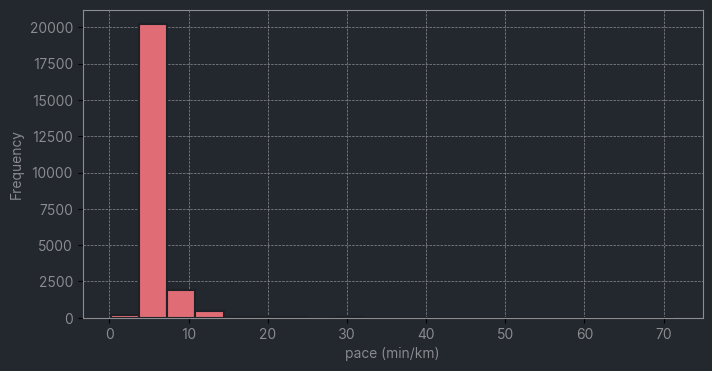

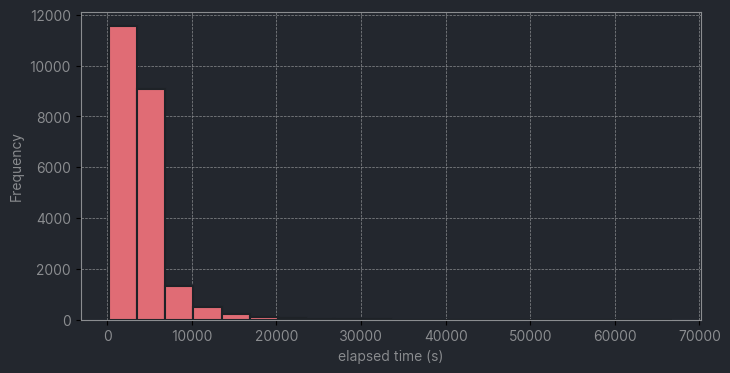

In [46]:
my_freqdist(data["pace (min/km)"])
my_freqdist(data["elapsed time (s)"])

Slow average pace are still valid and can still appear in the deployed incoming data, so I will leave these values in. However, I can eliminate paces that are impossibly fast as these are invalid.

In [47]:
print(f'Fastest pace {data["pace (min/km)"].min():.5f} min/km')
print(f'Slowest pace {data["pace (min/km)"].max():.5f} min/km')
print(f"World record 100m pace (Usain Bolt): {9.58/60/0.1:.5f} min/km")
print(f"World record 60m pace (Christian Coleman): {6.34/60/0.06:.5f} min/km")

Fastest pace 0.17581 min/km
Slowest pace 71.37915 min/km
World record 100m pace (Usain Bolt): 1.59667 min/km
World record 60m pace (Christian Coleman): 1.76111 min/km


In [48]:
print(f"Implausibly fast rows: {data[data['pace (min/km)'] < 1.59].size}")
print(f"Percentage of total: {data[data['pace (min/km)'] < 1.59].size/data.shape[0]*100:.2f} %")
data[data["pace (min/km)"] < 1.59]

Implausibly fast rows: 50
Percentage of total: 0.22 %


,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%)
11128,3460571,2019-05-26 07:09:00,33105.1,2752,935.6,144.4,1.385486,0.460520,False,2.826151
12261,2913078,2016-10-17 17:03:00,2130.7,189,0.0,127.8,1.478387,-0.630577,False,0.000000
13953,12740383,2019-08-23 23:22:00,41746.6,2001,2513.0,123.6,0.798867,-1.572014,False,6.019652
19643,18736169,2019-02-05 16:59:00,10683.0,399,47.6,135.3,0.622484,-0.793141,False,0.445568
37941,22891135,2018-06-23 04:31:00,36593.1,386,347.4,144.7,0.175807,-0.394992,False,0.949359


As before, I stated that I would impute data if the affected rows were more than 2% but less than 10%. Therefore, I will delete these data points instead of imputing them.

In [49]:
data.drop(data[data["pace (min/km)"] < 1.59].index, inplace=True)

I can also delete paces that exceed the world record pace for long distances. For each race distance, I'll delete rows that have both a distance greater than that distance and a time shorter than the world record time for that distance.

In [50]:
fastest_distances = {
    '50k':
        {
            'time': 2*3600+40*60+13, 
            'distance': 50000
        },
    'marathon': 
        {
            'time': 2*3600+35, 
            'distance': 42195
        }, 
    'half': 
        {
            'time': 57*60+31, 
            'distance': 42195/2
        }, 
    '15k': 
        {
            'time': 44*60+14, 
            'distance': 15000
        }, 
    '12k': 
        {
            'time': 35*60+57, 
            'distance': 12000
        }, 
    '10k': 
        {
            'time': 26*60+11, 
            'distance': 10000
        }, 
    '8k': 
        {
            'time': 22*60+39, 
            'distance': 8000
        }, 
    '5k': 
        {
            'time': 13*60+38, 
            'distance': 5000
        }, 
    '1500m': 
        {
            'time': 3*60+26, 
            'distance': 1500
        }
    }

def valid_pace(row):

    for field in fastest_distances:
        if ((row['distance (m)'] > fastest_distances[field]['distance']) & (row['elapsed time (s)'] < fastest_distances[field]['time'])):
            return True

data["flag"] = data.apply(valid_pace, axis=1)
data[data["flag"]==True]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%)
6716,7947798,2015-11-18 18:36:00,1868.8,202,0.0,157.7,1.801513,1.802741,True,0.000000
12194,2913078,2017-02-04 16:24:00,1579.7,184,0.0,91.9,1.941297,-2.253710,True,0.000000
19644,18736169,2019-02-04 17:45:00,15906.0,1914,211.9,126.8,2.005533,-1.324577,True,1.332202
29568,2138770,2018-10-16 11:38:00,43630.2,6673,453.2,139.3,2.549075,-0.420376,True,1.038730
29580,2138770,2018-09-03 14:52:00,67299.7,7953,584.0,134.6,1.969548,-0.712452,True,0.867760
31278,12642956,2019-01-27 08:07:00,15070.0,1926,159.0,164.3,2.130060,0.487835,True,1.055076
31808,11284478,2017-05-26 06:30:00,22841.0,2537,1175.0,163.3,1.851203,0.832833,True,5.144258


In [51]:
data.drop(data[data['flag'] == True].index, inplace=True)

### **Univariate Analysis: Timestamp**

I'll do more feature engineering and construct another feature that indicates the time since the data point was performed. This is because runs that are more recent will be more indicative of future performance.

In [52]:
# Calculate the amount of time since that run - the datum doesn't matter 

data["time ago (s)"] = datetime(2023, 1, 1) - data["timestamp"]

data["time ago (s)"] = data["time ago (s)"].apply(lambda x: x.total_seconds())

data.head()

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%),time ago (s)
0,18042525,2019-12-15 09:08:00,2965.8,812,17.4,150.3,4.563131,0.516032,None,0.586688,96130320.0
1,18042525,2019-12-10 19:27:00,10020.8,3290,52.2,160.8,5.471952,1.341660,None,0.520916,96525180.0
2,18042525,2019-12-03 19:46:00,12132.2,4027,249.0,148.9,5.532110,0.405948,None,2.052390,97128840.0
3,18042525,2019-11-26 19:46:00,11631.5,4442,194.0,136.2,6.364900,-0.592669,None,1.667885,97733640.0
4,18042525,2019-11-19 19:45:00,11708.1,4022,250.7,146.0,5.725381,0.177917,None,2.141253,98338500.0


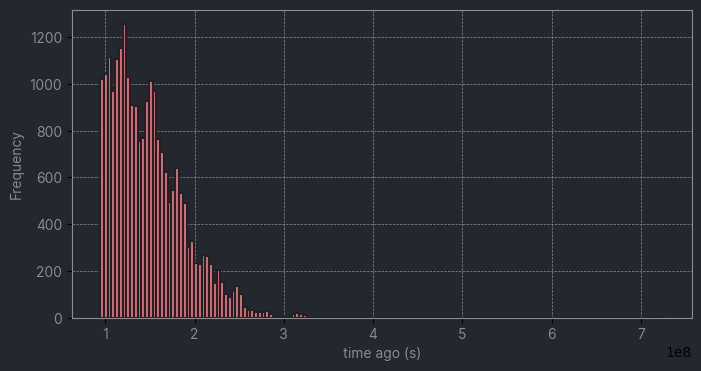

In [53]:
my_freqdist(data["time ago (s)"],n_bins=150)

In [54]:
print(f'Newest data point: {max(data["timestamp"])}')
print(f'Oldest data point: {min(data["timestamp"])}')

Newest data point: 2020-01-06 05:24:00
Oldest data point: 2000-01-04 12:06:00


The timestamp column has no problems.

## **Feature Scaling**

### **Frequency Distributions & Transformation**

In [55]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import yeojohnson

#### **Elevation**

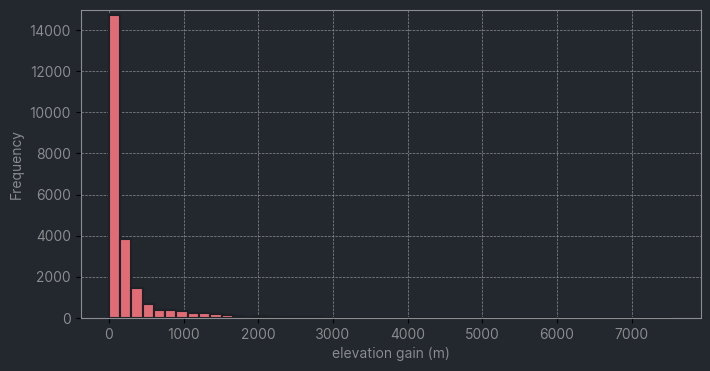

Skewness: 4.30
Kurtosis: 29.17


In [56]:
x = data["elevation gain (m)"]

my_freqdist(x,n_bins=50, ylim=[0,15000])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

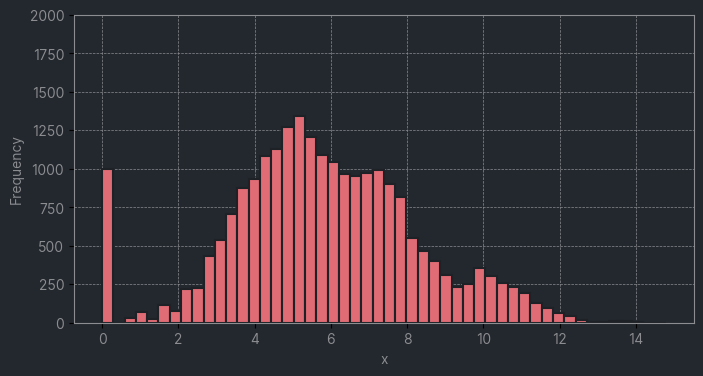

Skewness: 0.01
Kurtosis: 0.23


In [57]:
from scipy.stats import boxcox

x = boxcox(data["elevation gain (m)"]+1)[0]

my_freqdist(x,n_bins=50, ylim=[0,2000])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

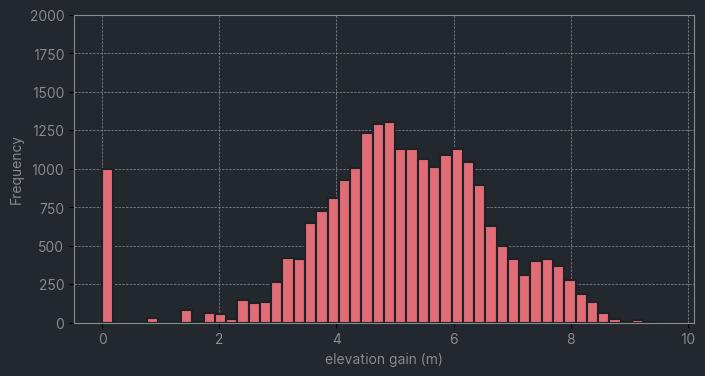

Skewness: -0.84
Kurtosis: 1.45


In [58]:
x = np.arcsinh(data["elevation gain (m)"])

my_freqdist(x,n_bins=50, ylim=[0,2000])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

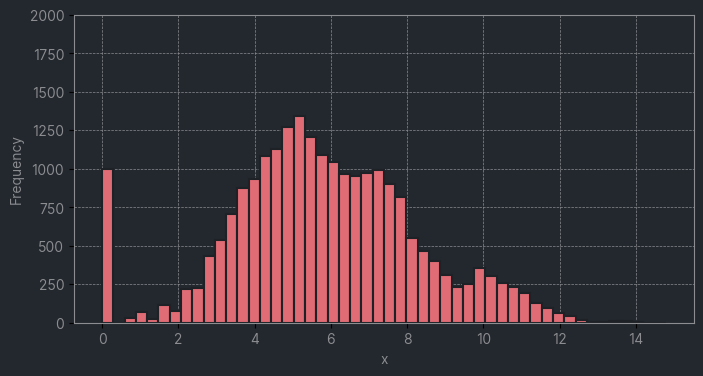

Skewness: 0.01
Kurtosis: 0.23


In [59]:
x = yeojohnson(data["elevation gain (m)"])[0]

my_freqdist(x,n_bins=50, ylim=[0,2000])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

I will use Yeo-Johnson to scale Elevation

In [60]:
data["elevation"] = yeojohnson(data["elevation gain (m)"])[0]

#### **Distance**

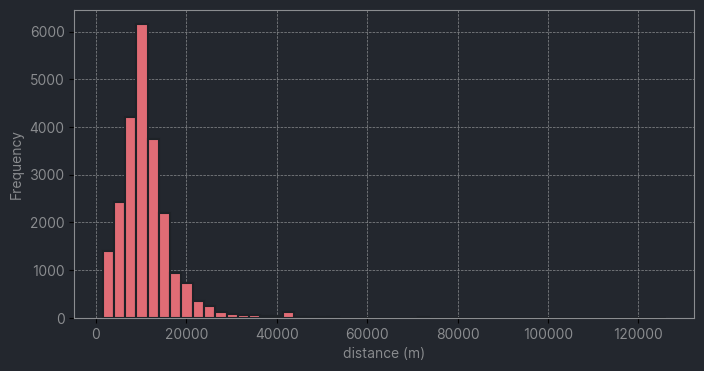

Skewness: 3.39
Kurtosis: 26.17


In [61]:
x = data['distance (m)']

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

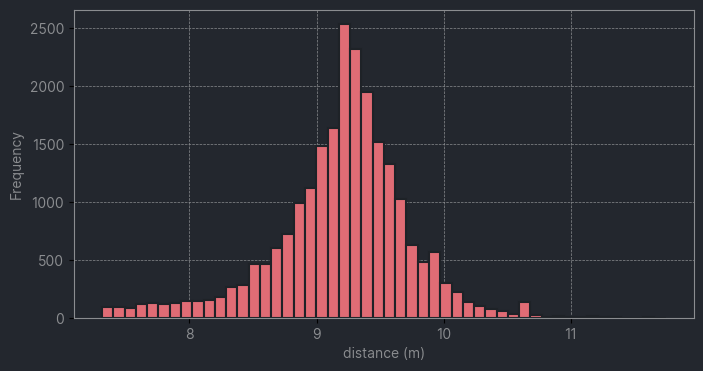

Skewness: -0.56
Kurtosis: 1.73


In [62]:
x = np.log(data["distance (m)"])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

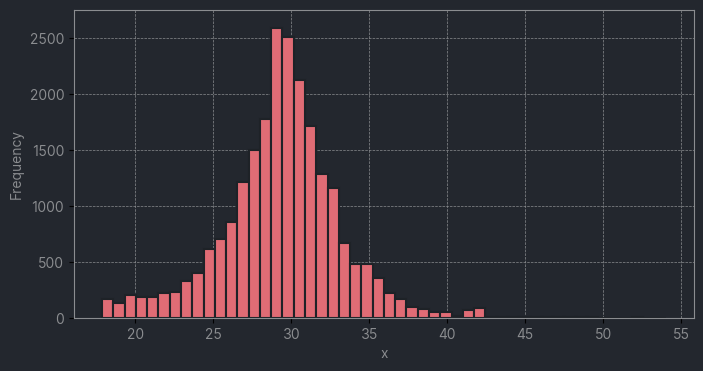

Skewness: 0.07
Kurtosis: 1.90


In [63]:
x = boxcox(data["distance (m)"])[0]

my_freqdist(x,n_bins=50, ylim=[0,2750])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

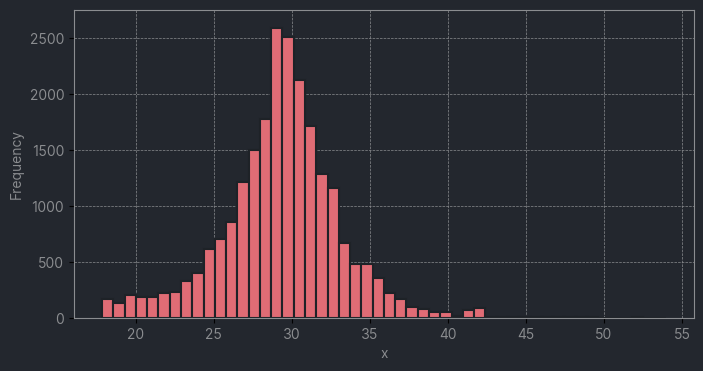

Skewness: 0.06
Kurtosis: 1.90


In [64]:
x = yeojohnson(data["distance (m)"])[0]

my_freqdist(x,n_bins=50, ylim=[0,2750])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

I will use Yeo-Johnson to scale Distance.

In [65]:
data["distance"] = yeojohnson(data["distance (m)"])[0]

#### **Heart Rate**

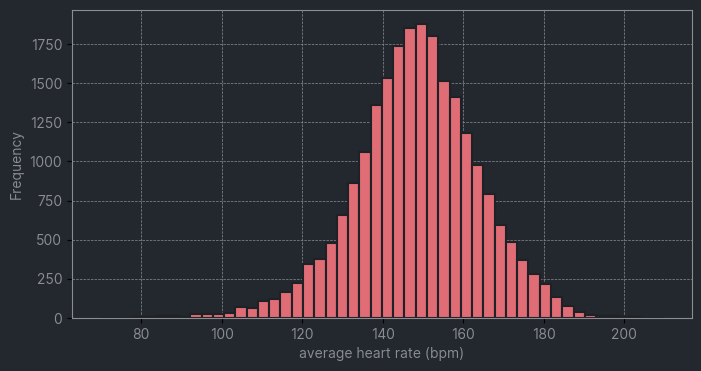

Skewness: -0.28
Kurtosis: 0.81


In [66]:
x = data['average heart rate (bpm)']

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

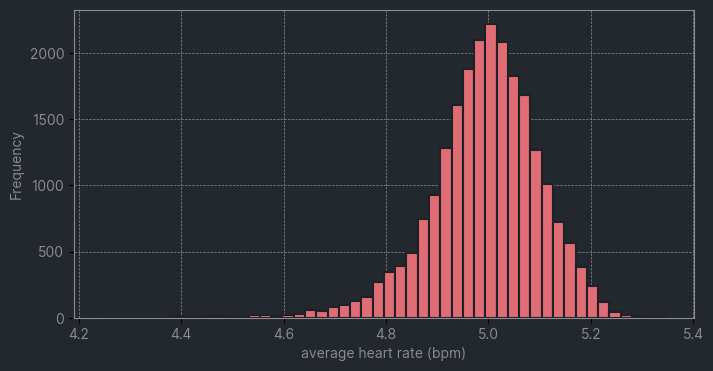

Skewness: -0.78
Kurtosis: 2.10


In [67]:
x = np.log(data['average heart rate (bpm)'])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

Heart Rate does not need to be transformed as it is already highly normally distributed.

In [68]:
data["hr"] = data['average heart rate (bpm)']

#### **Time Ago**

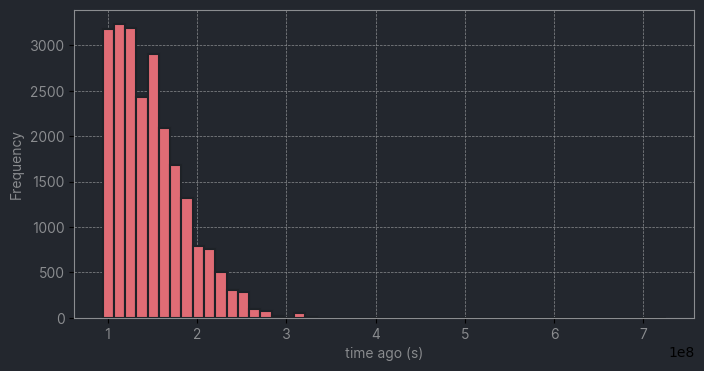

Skewness: 1.09
Kurtosis: 2.68


In [69]:
x = data["time ago (s)"]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

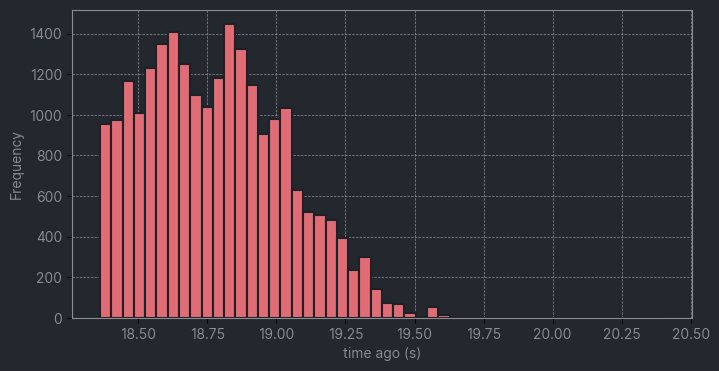

Skewness: 0.41
Kurtosis: -0.44


In [70]:
x = np.log(data["time ago (s)"])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

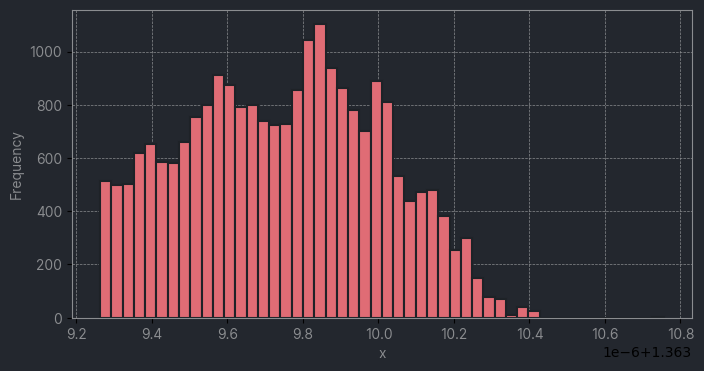

Skewness: 0.00
Kurtosis: -0.84


In [71]:
x = boxcox(data["time ago (s)"])[0]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

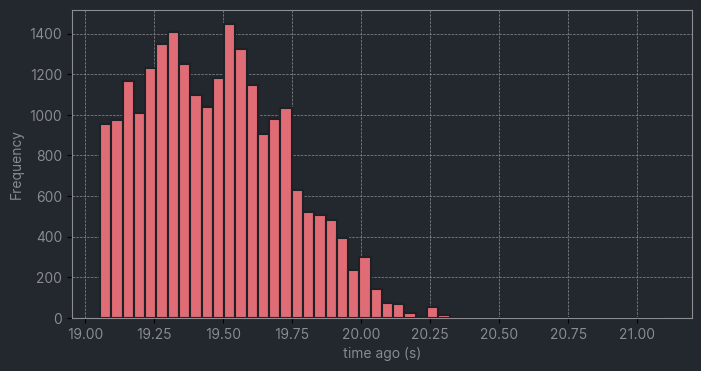

Skewness: 0.41
Kurtosis: -0.44


In [72]:
x = np.arcsinh(data["time ago (s)"])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

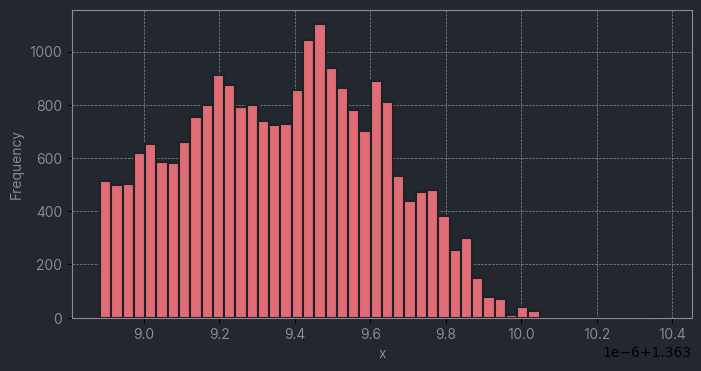

Skewness: 0.00
Kurtosis: -0.84


In [73]:
x = yeojohnson(data["time ago (s)"])[0]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

I will also use Yeo-Johnson to scale Time-Ago

In [74]:
data["time_ago"] = yeojohnson(data["time ago (s)"])[0]

#### **Time**

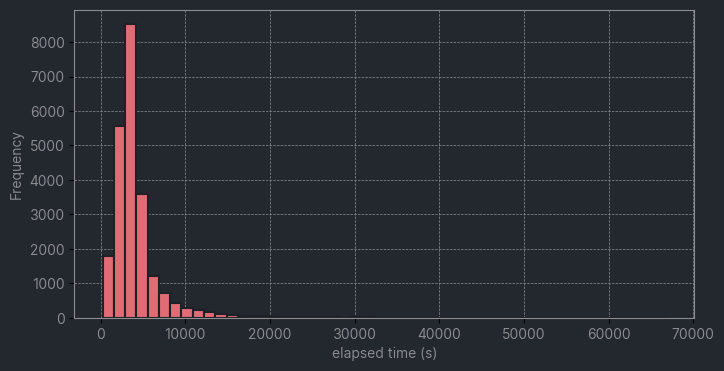

Skewness: 5.07
Kurtosis: 46.05


In [75]:
x = data["elapsed time (s)"]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

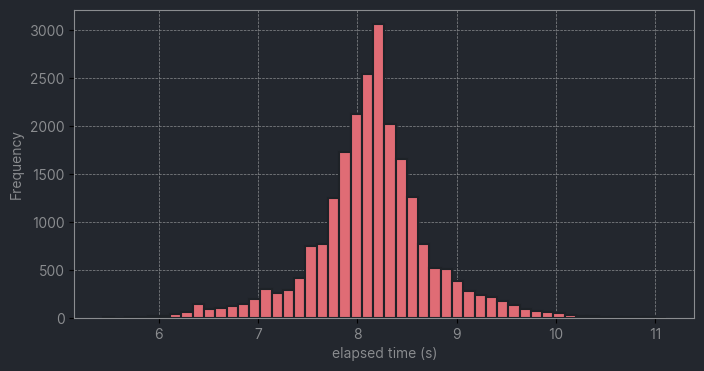

Skewness: -0.04
Kurtosis: 2.07


In [76]:
x = np.log(data["elapsed time (s)"])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

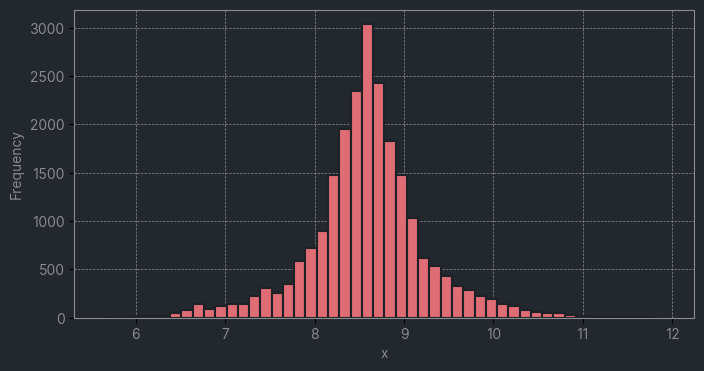

Skewness: 0.01
Kurtosis: 2.08


In [77]:
x = yeojohnson(data["elapsed time (s)"])[0]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

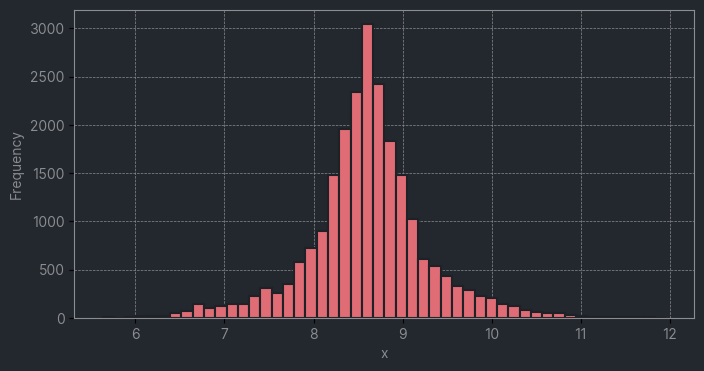

Skewness: 0.01
Kurtosis: 2.08


In [78]:
x = boxcox(data["elapsed time (s)"])[0]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

Yeo-Johnson and BoxCox perform identically. For consistency's sake, I'll use Yeo-Johnson to scale Time.

### **Summary of Transformations and Variables**

| **Variable** | **Type** | **Transform** |
|--------------|----------|---------------|
| Distance     | Input    | Yeo-Johnson    |
| Elevation    | Input    | Yeo-Johnson    |
| HR           | Input    | None           |
| Time-Ago     | Input    | Yeo-Johnson    |
| Time         | Output   | Yeo-Johnson    |


### **Scaling**

In [79]:
def rescale(series):
    '''
    Uses min-max scaling on a pandas Series
    '''

    return (series - series.min()) / (series.max() - series.min())

def minmax_scale(x_train, 
                 x_test=None, 
                 y_train=None, y_test=None):
    '''
    Uses min-max scaling to scale the train and test data sets according to the min-max of the train dataset only.
    '''

    x_max = x_train.max()
    x_min = x_train.min()
    x_train = (x_train-x_min)/(x_max-x_min)

    if x_test is not None:
        x_test  = (x_test -x_min)/(x_max-x_min)

    if y_train is not None and y_test is not None:
        y_max = y_train.max()
        y_min = y_train.min()
        y_train = (y_train-y_min)/(y_max-y_min)
        y_test  = (y_test -y_min)/(y_max-y_min)
        
        return x_train, x_test, y_train, y_test
    
    else:
        if x_test is None:
            return x_train
        else:
            return x_train, x_test

def yj_transform(train_set, test_set=None):
    '''
    Uses Yeo-Johnson to scale the train and test data sets according to the distribution of the train dataset only. 
    
    Returns the power transformer fitted for the train set, and the transformed+maxmin scaled train set (and test set if the test set was provided)
    '''

    yjpt = PowerTransformer(method='yeo-johnson')

    train_set_transformed = yjpt.fit_transform(train_set.values.reshape(-1,1))
    train_set_transformed = train_set_transformed.flatten()

    if test_set is not None:
        test_set_transformed = yjpt.transform(test_set.values.reshape(-1,1))

        test_set_transformed = test_set_transformed.flatten()

        train_set_transformedscaled, test_set_transformedscaled = minmax_scale(train_set_transformed, test_set_transformed)

        return yjpt, train_set_transformedscaled, test_set_transformedscaled 
    
    else:

        train_set_transformedscaled = minmax_scale(train_set_transformed)

        return yjpt, train_set_transformedscaled



## **Pre-Visualising the Relationshing**

Let's plot 3 variables against each other as the 3D space will allow us to easily visualise the correlations.

In [80]:
athletes = data["athlete"].unique()
athlete_idx = 6

my_scatter(x=data.loc[data["athlete"] == athletes[athlete_idx]]["time_ago"],
           y=data.loc[data["athlete"] == athletes[athlete_idx]]["distance"],
           z=data.loc[data["athlete"] == athletes[athlete_idx]]["time"],
           c=data.loc[data["athlete"] == athletes[athlete_idx]]["time_ago"],
           height=600)

KeyError: 'time'

In [ ]:
my_scatter(x=data.loc[data["athlete"] == athletes[athlete_idx]]["hr"],
           y=data.loc[data["athlete"] == athletes[athlete_idx]]["distance"],
           z=data.loc[data["athlete"] == athletes[athlete_idx]]["pace (min/km)"],
           c=data.loc[data["athlete"] == athletes[athlete_idx]]["gradient (%)"],
           height=600)

Plotting Pace instead of Time shows that Time is a much more predictable variable to correlate, and that I was correct in using Time as a predictor instead of Pace.

Now that the data is processed and normalised, I'll create an initial Neural Network (NN) to see the minimum number of nodes to capture the input/output map with at least 90% accuracy for a given user. This will allow me to decide whether a helper model for fine-tuning is feasible.

The possible outcomes will be:
* Low number of nodes: the output of the helper fine-tuning model can be the changes to weights and biases for each node
* High number of nodes: there are too many weights and biases to create a neural network with these as outputs - I'll have to fine tune base models directly, and probably use a greater number of clusters 
* Accuracy can't be captured with 90% accuracy: this indicates that there is poor correlation of the input with the output

## **EDA Conclusion**

The EDA has now been completed. The data is cleaned, transformed and scaled.

# **Model Strategy**

Each athlete has 1 model etc.

# **Train-Test Split**

I will split my data not randomly, but according to how much many runs each athlete has. The athletes with too few runs to be useful will be used for testing.

don't transform entire datasets. Transform for each base model

In [82]:
len(data["athlete"].unique())

106

In [83]:
athlete_counts = data['athlete'].value_counts()
data['row_count'] = data['athlete'].map(athlete_counts)
data.drop_duplicates(subset='athlete').sort_values(by='row_count')[data["row_count"]<30].shape[0]

C:\Users\hobly\AppData\Local\Temp\ipykernel_15576\3053232410.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data.drop_duplicates(subset='athlete').sort_values(by='row_count')[data["row_count"]<30].shape[0]


10

In [84]:
ath_mostruns = data.drop_duplicates(subset='athlete')[data["row_count"]==data["row_count"].max()]["athlete"].values[0]

data[data["athlete"]==ath_mostruns].sort_values(by='average heart rate (bpm)', ascending=False)


C:\Users\hobly\AppData\Local\Temp\ipykernel_15576\2129297842.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ath_mostruns = data.drop_duplicates(subset='athlete')[data["row_count"]==data["row_count"].max()]["athlete"].values[0]


,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%),time ago (s),elevation,distance,hr,time_ago,row_count
39463,19023831,2018-09-23 06:52:00,11660.1,3557,40.8,173.4,5.084290,2.948611,None,0.349911,134845680.0,4.568641,30.386830,173.4,1.363009,684
39849,19023831,2017-03-11 11:19:00,1571.3,360,12.8,171.7,3.818494,2.806869,None,0.814612,183300060.0,3.021274,18.080056,171.7,1.363010,684
39266,19023831,2019-07-27 18:57:00,3008.3,1052,21.3,171.4,5.828319,2.781856,None,0.708041,108277380.0,3.669356,21.500317,171.4,1.363009,684
39833,19023831,2017-04-02 11:30:00,10020.1,2538,0.0,167.7,4.221515,2.473358,None,0.000000,181398600.0,0.000000,29.258423,167.7,1.363010,684
39517,19023831,2018-07-24 18:00:00,1834.3,896,9.4,166.3,8.141162,2.356629,None,0.512457,140076000.0,2.654291,18.851954,166.3,1.363009,684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39652,19023831,2018-01-07 10:10:00,4010.0,1145,14.7,110.2,4.758936,-2.320867,None,0.366584,157211400.0,3.192273,23.174312,110.2,1.363009,684
39598,19023831,2018-04-07 08:23:00,5038.9,1359,21.4,109.4,4.495029,-2.387569,None,0.424696,149441820.0,3.675553,24.580805,109.4,1.363009,684
39513,19023831,2018-07-29 08:03:00,2029.6,962,9.7,107.1,7.899750,-2.579338,None,0.477927,139679820.0,2.690696,19.370757,107.1,1.363009,684
39875,19023831,2017-01-29 10:46:00,28839.3,9758,247.5,107.1,5.639295,-2.579338,None,0.858204,186844440.0,7.467297,37.955961,107.1,1.363010,684


In [85]:
race_idx_19023831 = 39266 # index in data df for a race by athlete 19023831

**quick and dirty test to see if it's feasible**

Using the athlete with the most data, I'll train a model on all of that athlete's runs, except for 1 run which took on 2018-09-23 06:52:00 that appears to be a race. I'll then predict on that point and assess the accuracy of the model. If the model is unable to predict accurately on this data point, then it may be infeasible to produce a generalisable model to predict any runner's race time.

In [ ]:
# transform all data for all athletes with the same fit

import torch
from sklearn.model_selection import train_test_split

# create new columns for transformed+scaled data
yjpt_distance, data["distance"] = yj_transform(data["distance"])
yjpt_elevation, data["elevation"] = yj_transform(data["elevation"])
data["hr"] = minmax_scale(data["hr"])
yjpt_time, data["time"] = yj_transform(data["time"])
yjpt_timeago, data["time_ago"] = yj_transform(data["time_ago"])

input_cols_scaled = ["distance", "elevation", "hr", "time_ago"]

data[input_cols_scaled].apply(rescale)

data[["athlete"]+input_cols_scaled].head()

y_race = data.loc[race_idx_19023831]["time"]
x_race = data.loc[race_idx_19023831][input_cols_scaled].values

X = data[data["athlete"]==ath_mostruns][input_cols_scaled].drop(race_idx_19023831)
y = data[data["athlete"]==ath_mostruns]["time"].drop(race_idx_19023831)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12)

x_train = torch.tensor(x_train.values).float()
y_train = torch.tensor(y_train.values).float()
x_test = torch.tensor(x_test.values).float()
y_test = torch.tensor(y_test.values).float()

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicNN(nn.Module):
    def __init__(self):

        torch.manual_seed(12) # set Torch's random seed for initialised weights

        super(BasicNN, self).__init__()
        self.fc1 = nn.Linear(4, 10)  # 4 input features, 10 neurons in first hidden layer
        self.fc2 = nn.Linear(10, 10)  # 10 neurons in first hidden layer, 10 neurons in second hidden layer
        self.fc4 = nn.Linear(10, 1)  # 10 neurons in second hidden layer, 1 output

    def forward(self, x):
        x = F.relu(self.fc1(x))  # ReLU activation function for first hidden layer
        x = F.relu(self.fc2(x))  # ReLU activation function for second hidden layer
        x = self.fc4(x)  # No activation function for output layer (for regression tasks)
        return x

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

model = BasicNN()

# hyperparameters for training
epochs = 500
batch_size = 20
learning_rate = 0.001
# loss criterion: MSE
# optimizer: Adam

train_dataset = TensorDataset(x_train, y_train)

# Create a DataLoader for batching
torch.manual_seed(42) # set Torch's random seed for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):  # loop over the dataset multiple times

    training_loss = 0.0

    for inputs, labels in train_loader:

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward propogation
        outputs = model(inputs)
        loss = criterion(outputs, labels) # compute losses
        loss.backward() # compute loss function gradients
        optimizer.step() # update weights and biases

        training_loss += loss.item()

    print(f'Epoch {str(epoch + 1).zfill(3)}, loss: {training_loss/len(x_train):.5f}')



Epoch 001, loss: 0.01036
Epoch 002, loss: 0.00503
Epoch 003, loss: 0.00191
Epoch 004, loss: 0.00081
Epoch 005, loss: 0.00070
Epoch 006, loss: 0.00067
Epoch 007, loss: 0.00070
Epoch 008, loss: 0.00070
Epoch 009, loss: 0.00067
Epoch 010, loss: 0.00069
Epoch 011, loss: 0.00067
Epoch 012, loss: 0.00066
Epoch 013, loss: 0.00068
Epoch 014, loss: 0.00067
Epoch 015, loss: 0.00069
Epoch 016, loss: 0.00066
Epoch 017, loss: 0.00066
Epoch 018, loss: 0.00065
Epoch 019, loss: 0.00067
Epoch 020, loss: 0.00068
Epoch 021, loss: 0.00065
Epoch 022, loss: 0.00067
Epoch 023, loss: 0.00066
Epoch 024, loss: 0.00066
Epoch 025, loss: 0.00065
Epoch 026, loss: 0.00064
Epoch 027, loss: 0.00065
Epoch 028, loss: 0.00067
Epoch 029, loss: 0.00065
Epoch 030, loss: 0.00068
Epoch 031, loss: 0.00065
Epoch 032, loss: 0.00067
Epoch 033, loss: 0.00067
Epoch 034, loss: 0.00066
Epoch 035, loss: 0.00066
Epoch 036, loss: 0.00066
Epoch 037, loss: 0.00065
Epoch 038, loss: 0.00066
Epoch 039, loss: 0.00065
Epoch 040, loss: 0.00065


In [94]:
# transform the variables wrt athlete 19023831 only
from sklearn.model_selection import train_test_split
import torch

input_cols = ["distance (m)", "elevation gain (m)", "average heart rate (bpm)", "time ago (s)"]
# input_cols = ["distance (m)", "elevation gain (m)", "average heart rate (bpm)"]


class athlete_data():

    def __init__(self, athlete, race_idx):

        self.athlete = athlete
        self.race_idx = race_idx

        self.y_race = data.loc[self.race_idx]["elapsed time (s)"]
        self.x_race = data.loc[self.race_idx][input_cols].values

        self.X = data[data["athlete"]==ath_mostruns][input_cols].drop(self.race_idx)
        self.y = data[data["athlete"]==ath_mostruns]["elapsed time (s)"].drop(self.race_idx)

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.2, random_state=30)

        self.x_train_scaled = pd.DataFrame()
        self.y_train_scaled = pd.DataFrame()
        self.x_test_scaled = pd.DataFrame()
        self.y_test_scaled = pd.DataFrame()

        self.yjpt_distance, self.x_train_scaled["distance"], self.x_test_scaled["distance"] = yj_transform(self.x_train["distance (m)"], self.x_test["distance (m)"])
        self.yjpt_elevation, self.x_train_scaled["elevation"], self.x_test_scaled["elevation"] = yj_transform(self.x_train["elevation gain (m)"], self.x_test["elevation gain (m)"])
        self.yjpt_timeago, self.x_train_scaled["timeago"], self.x_test_scaled["timeago"] = yj_transform(self.x_train["time ago (s)"], self.x_test["time ago (s)"])
        self.yjpt_time, self.y_train_scaled["time"], self.y_test_scaled["time"] = yj_transform(self.y_train, self.y_test)

        hr_train, hr_test = minmax_scale(self.x_train["average heart rate (bpm)"], self.x_test["average heart rate (bpm)"])
        self.x_train_scaled["hr"], self.x_test_scaled["hr"] = hr_train.values, hr_test.values

        self.x_train_vals = self.x_train_scaled.values
        self.x_test_vals = self.x_test_scaled.values
        self.y_train_vals = self.y_train_scaled.values
        self.y_test_vals = self.y_test_scaled.values

        self.x_train_tensor = torch.tensor(self.x_train_vals).float()
        self.x_test_tensor = torch.tensor(self.x_test_vals).float()
        self.y_train_tensor = torch.tensor(self.y_train_vals).float()
        self.y_test_tensor = torch.tensor(self.y_test_vals).float()

        self.x_race_transformed = np.array([
            self.yjpt_distance.transform(self.x_race[0].reshape(-1,1))[0][0],
            self.yjpt_elevation.transform(self.x_race[1].reshape(-1,1))[0][0],
            self.x_race[2],
            self.yjpt_timeago.transform(self.x_race[2].reshape(-1,1))[0][0],
            ])
        _, self.x_race_scaled = minmax_scale(self.x_train, self.x_race_transformed)
        self.x_race_tensor = torch.tensor([self.x_race_scaled]).float()

    def y2minutes(self, y_pred):
        if str(type(y_pred)) == "<class 'torch.Tensor'>":
            y_pred = y_pred.detach().numpy()

        # descale
        y_pred * (self.y_train.max() - self.y_train.min()) + self.y_train.min()

        # detransform
        if len(y_pred) == 1:
            return self.yjpt_time.inverse_transform(y_pred.reshape(-1,1))[0][0]/60
        else:
            return self.yjpt_time.inverse_transform(y_pred.reshape(-1,1))/60
        

data19023831 = athlete_data(athlete = ath_mostruns, race_idx = race_idx_19023831)

C:\Users\hobly\AppData\Local\Temp\ipykernel_15576\3911225553.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.x_race_tensor = torch.tensor([self.x_race_scaled]).float()


In [442]:
data19023831.y_train.max()

16499

In [88]:
def mape(pred_tensor, true_tensor):
    '''
    Mean Absolute Percentage Error loss function
    '''
    eps = np.finfo(np.float64).eps

    return torch.sum(torch.abs((pred_tensor-true_tensor+eps)/(true_tensor+eps)))/true_tensor.size(0)


def mape_actualtime(pred_tensor, true_tensor):
    '''
    Uses MAPE on the descaled and detransformed time values
    '''

    pred_seconds = torch.tensor(data19023831.y2minutes(pred_tensor), requires_grad=True).float()
    true_seconds = torch.tensor(data19023831.y2minutes(true_tensor), requires_grad=True).float()

    return torch.sum(torch.abs((pred_seconds-true_seconds)/(true_seconds)))/true_seconds.size(0)

In [472]:
# model = BasicNN()

# pred = model(data19023831.x_test_tensor)

# mape_actualtime(pred, data19023831.y_test_tensor)

inputs, labels = next(iter(train_loader))

pred_batch = model(inputs)

loss = mape_actualtime(pred_batch, labels)

loss

tensor(0.1942, grad_fn=<DivBackward0>)

In [95]:
model = BasicNN()

y_pred_train = model(data19023831.x_train_tensor)
y_pred_test = model(data19023831.x_test_tensor)

print(mape(y_pred_train,data19023831.y_train_tensor))
print(mape(y_pred_test,data19023831.y_test_tensor))
print(nn.MSELoss()(y_pred_train,data19023831.y_train_tensor))
print(nn.MSELoss()(y_pred_test,data19023831.y_test_tensor))

tensor(4.0540e+11, grad_fn=<DivBackward0>)
tensor(1.2347, grad_fn=<DivBackward0>)
tensor(0.3274, grad_fn=<MseLossBackward0>)
tensor(0.3067, grad_fn=<MseLossBackward0>)


In [501]:

model = BasicNN()
print(f'{data19023831.y2minutes(model(data19023831.x_race_tensor)):.2f}')
print(f'{data19023831.y_race/60:.2f}')

42.36
17.53


Epoch 001 | Average training loss: 0.28339 | Average testing loss: 0.27199
Epoch 002 | Average training loss: 0.28317 | Average testing loss: 0.27199
Epoch 003 | Average training loss: 0.28209 | Average testing loss: 0.27199
Epoch 004 | Average training loss: 0.28296 | Average testing loss: 0.27199
Epoch 005 | Average training loss: 0.28271 | Average testing loss: 0.27199
Epoch 006 | Average training loss: 0.28298 | Average testing loss: 0.27199
Epoch 007 | Average training loss: 0.28385 | Average testing loss: 0.27199
Epoch 008 | Average training loss: 0.28260 | Average testing loss: 0.27199
Epoch 009 | Average training loss: 0.28313 | Average testing loss: 0.27199
Epoch 010 | Average training loss: 0.28225 | Average testing loss: 0.27199
Epoch 011 | Average training loss: 0.28336 | Average testing loss: 0.27199
Epoch 012 | Average training loss: 0.28264 | Average testing loss: 0.27199
Epoch 013 | Average training loss: 0.28231 | Average testing loss: 0.27199
Epoch 014 | Average train

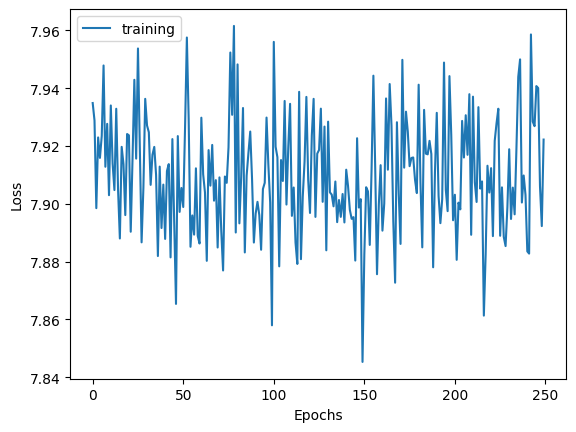

In [100]:
from torch.utils.data import DataLoader, TensorDataset

model = BasicNN()

# hyperparameters for training
epochs = 250
batch_size = 20
learning_rate = 0.1
# optimizer: Adam

train_dataset = TensorDataset(data19023831.x_train_tensor, data19023831.y_train_tensor)

# Create a DataLoader for batching
torch.manual_seed(42) # set Torch's random seed for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
# criterion = mape
criterion = mape_actualtime
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# trackers
training_losses = []
testing_losses = []

for epoch in range(epochs):  # loop over the dataset multiple times

    training_loss = 0 # sum of all losses of all batches (reset each epoch)

    # train on every batch
    for inputs, labels in train_loader:

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward propogation
        outputs = model(inputs)
        loss = criterion(outputs, labels) # compute losses
        loss.backward() # compute loss function gradients
        optimizer.step() # update weights and biases

        training_loss += loss.item() # average training loss in that batch

    with torch.no_grad(): # prevents update of optimizer  
        y_pred = model(data19023831.x_test_tensor)
        test_loss = criterion(y_pred, data19023831.y_test_tensor).item()
    training_losses.append(training_loss)
    testing_losses.append(test_loss)

    print(f'Epoch {str(epoch + 1).zfill(3)} | Average training loss: {training_loss/len(train_loader):.5f} | Average testing loss: {test_loss:.5f}')

plt.figure()
plt.plot(training_losses, label='training')
# plt.plot(testing_losses, label='testing')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

print(f'{data19023831.y2minutes(model(data19023831.x_race_tensor)):.2f}')
print(f'{data19023831.y_race/60:.2f}')

In [520]:
data19023831.X

,distance (m),elevation gain (m),average heart rate (bpm)
39159,7464.0,63.2,120.3
39160,27072.2,168.7,146.7
39161,6337.5,62.8,146.1
39162,8184.9,45.0,141.3
39163,14104.0,61.4,144.5
...,...,...,...
39915,6705.6,0.0,122.9
39916,6199.9,14.9,136.5
39917,9011.3,47.8,148.8
39918,9996.3,36.9,138.4


My suspicion is that MSE is not suitable for this application. 10 minutes is a small MSE because it is relative to the scale of the entire dataset, not the y-value itself (which could be a 5k time)

In [321]:
with torch.no_grad(): # prevents update of optimizer  
    y_pred = model(data19023831.x_test_tensor)
    test_loss = criterion(y_pred, data19023831.y_test_tensor).item()
    print(test_loss)

test_loss = 0
for i in range(len(data19023831.x_test_tensor)):
    with torch.no_grad(): # prevents update of optimizer  
        y_pred = model(data19023831.x_test_tensor[i])
        test_loss += criterion(y_pred, data19023831.y_test_tensor).item()
print(test_loss/len(data19023831.x_test_tensor))

0.002527262782678008
0.031861167197136116


c:\Users\hobly\.virtualenvs\Distance-Running-Predictions-dOy-q8bO\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning:

Using a target size (torch.Size([137, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [345]:
len(train_loader)

28

In [337]:
criterion(y_pred, data19023831.y_test_tensor)

tensor(0.0025, grad_fn=<MseLossBackward0>)

In [344]:
total_loss = 0
for idx, xpt in enumerate(data19023831.x_test_tensor):
    total_loss += criterion(model(xpt), data19023831.y_test_tensor[idx])

total_loss/len(data19023831.x_test_tensor)

tensor(0.0025, grad_fn=<DivBackward0>)

In [340]:
criterion(model(data19023831.x_train_tensor), data19023831.y_train_tensor)

tensor(0.0033, grad_fn=<MseLossBackward0>)

In [342]:
total_loss = 0
for idx, xpt in enumerate(data19023831.x_train_tensor):
    total_loss += criterion(model(xpt), data19023831.y_train_tensor[idx])

total_loss/len(data19023831.x_train_tensor)

tensor(0.0033, grad_fn=<DivBackward0>)